<a href="https://colab.research.google.com/github/24aef3/ait23/blob/main/Copy_of_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, Embedding
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from urllib.request import urlretrieve
import numpy as np
import random
import sys
import re, cgi

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [2]:
# download first book
url_book1="http://www.gutenberg.org/files/2151/2151-0.txt"
url_book2="https://www.gutenberg.org/cache/epub/12410/pg12410.txt"

urlretrieve(url_book1, 'book1.txt')
text1 = open("book1.txt", encoding='utf-8').read().lower()
urlretrieve(url_book2, 'book2.txt')
text2 = open("book2.txt", encoding='utf-8').read().lower()

print('Number of characters in the text:', len(text1))
print('Number of characters in the text:', len(text2))

Number of characters in the text: 486583
Number of characters in the text: 2332266


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [3]:
chars1 = sorted(list((text1)))
chars2 = sorted(list((text2)))

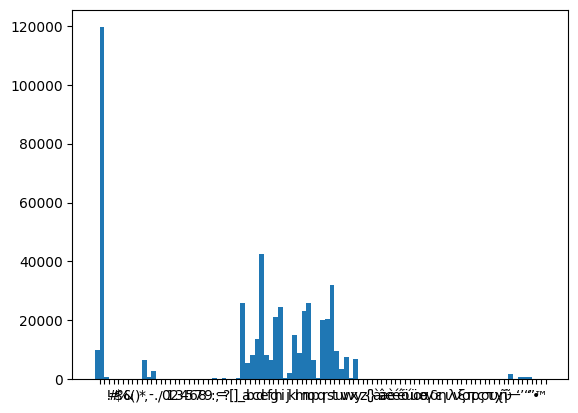

In [4]:
labels, values = zip(*Counter(chars1).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: 

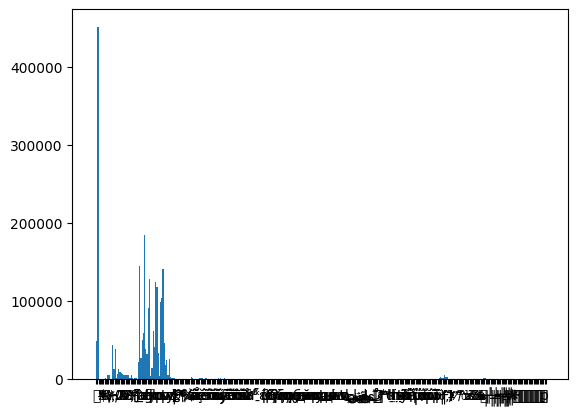

In [5]:
labels, values = zip(*Counter(chars2).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [6]:
both = [text1, text2]
labels = [0, 1]  # t1 = 0, t2 = 1
tok = Tokenizer(char_level=True)
tok.fit_on_texts(both)
alphabet_length = len(tok.word_index)

textSeqs = tok.texts_to_sequences(both)

In [7]:
def slide(text, label, seqLength):
    num_sequences = len(text) - seqLength + 1
    X = np.zeros((num_sequences, seqLength))
    y = np.zeros((num_sequences, 1))

    for i in range(num_sequences):
        X[i, :] = text[i:i + seqLength]
        y[i] = label

    return X, y

In [8]:
seqLength = 40
X_1, y_1 = slide(textSeqs[0], labels[0], seqLength)
X_2, y_2 = slide(textSeqs[1], labels[1], seqLength)
X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2], axis=0)

## Data splitting
Split the data into train, validate and test sets. Make 

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Model definition

---


Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [10]:
model = Sequential()
model.add(Embedding(alphabet_length + 1, 32, input_length=seqLength))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

## Model training
Train the model and apply early stopping.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=512, callbacks=[early_stopping])

Epoch 1/10
3854/3854 [==============================] - 1305s 338ms/step - loss: 0.2368 - accuracy: 0.9125 - val_loss: 0.1967 - val_accuracy: 0.9256
Epoch 2/10
3854/3854 [==============================] - 1301s 338ms/step - loss: 0.1914 - accuracy: 0.9271 - val_loss: 0.1739 - val_accuracy: 0.9325
Epoch 3/10
3854/3854 [==============================] - 1242s 322ms/step - loss: 0.1735 - accuracy: 0.9325 - val_loss: 0.1583 - val_accuracy: 0.9372
Epoch 4/10
3854/3854 [==============================] - 1267s 329ms/step - loss: 0.1618 - accuracy: 0.9361 - val_loss: 0.1454 - val_accuracy: 0.9414
Epoch 5/10
3854/3854 [==============================] - 1266s 328ms/step - loss: 0.1531 - accuracy: 0.9385 - val_loss: 0.1373 - val_accuracy: 0.9438
Epoch 6/10
3854/3854 [==============================] - 1272s 330ms/step - loss: 0.1464 - accuracy: 0.9407 - val_loss: 0.1277 - val_accuracy: 0.9471
Epoch 7/10
3854/3854 [==============================] - 1275s 331ms/step - loss: 0.1409 - accuracy: 0.9425

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss: ", loss);
print("Test accuracy: ", accuracy)

13213/13213 [==============================] - 144s 11ms/step - loss: 0.1098 - accuracy: 0.9542
Test loss:  0.10978671908378601
Test accuracy:  0.9542235732078552


## Confusion matrix
Calculate and display the confusion matrix.

13213/13213 [==============================] - 129s 10ms/step


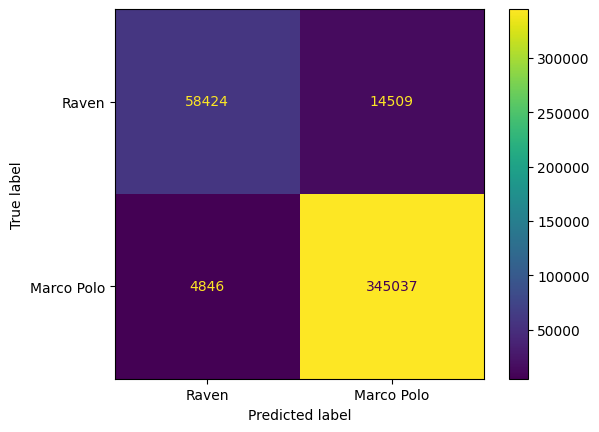

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=["Raven", "Marco Polo"])
disp.plot()
plt.show()